In [133]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset , random_split
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from models import ConvNet
from dataset import RotationDataset
from helper_functions import train_convnet, evaluate_classifier,rotation_collate

# test hyperparamters:

In [ ]:
ROTATION_NUMBER=4
CONV_BLOCKS=4
TRANSFER_LAYERS=3
assert TRANSFER_LAYERS<=CONV_BLOCKS
rotations=[i*360/(ROTATION_NUMBER) for i in range(ROTATION_NUMBER)]

## Datasets

In [135]:
dataset = datasets.MNIST(root='./data', 
                         train=True, 
                         download=True, 
                         transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', 
                        train=False, 
                        download=True, transform=transforms.ToTensor())

## Spliting Data

In [136]:
# Extract targets as a NumPy array
targets = np.array(dataset.targets)

# Select 10 indices for each class
indices = []
for digit in range(10):
    digit_indices = np.where(targets == digit)[0][:10]  # Take first 10 samples for each digit
    indices.extend(digit_indices)


supervised_dataset = Subset(dataset, indices)
unsupervised_dataset=Subset(dataset, np.setdiff1d(range(len(dataset)), indices))

print(f"Supervised dataset: {len(supervised_dataset)} samples")
print(f"Unsupervised dataset: {len(unsupervised_dataset)} samples")

Supervised dataset: 100 samples
Unsupervised dataset: 59900 samples


In [137]:
unsupervised_train_set, unsupervised_val_set = random_split(unsupervised_dataset, 
                                                            [0.9, 0.1])

print(f"Unsupervised training set: {len(unsupervised_train_set)} samples")
print(f"Unsupervised validation set: {len(unsupervised_val_set)} samples")


Unsupervised training set: 53910 samples
Unsupervised validation set: 5990 samples


## Visulaize

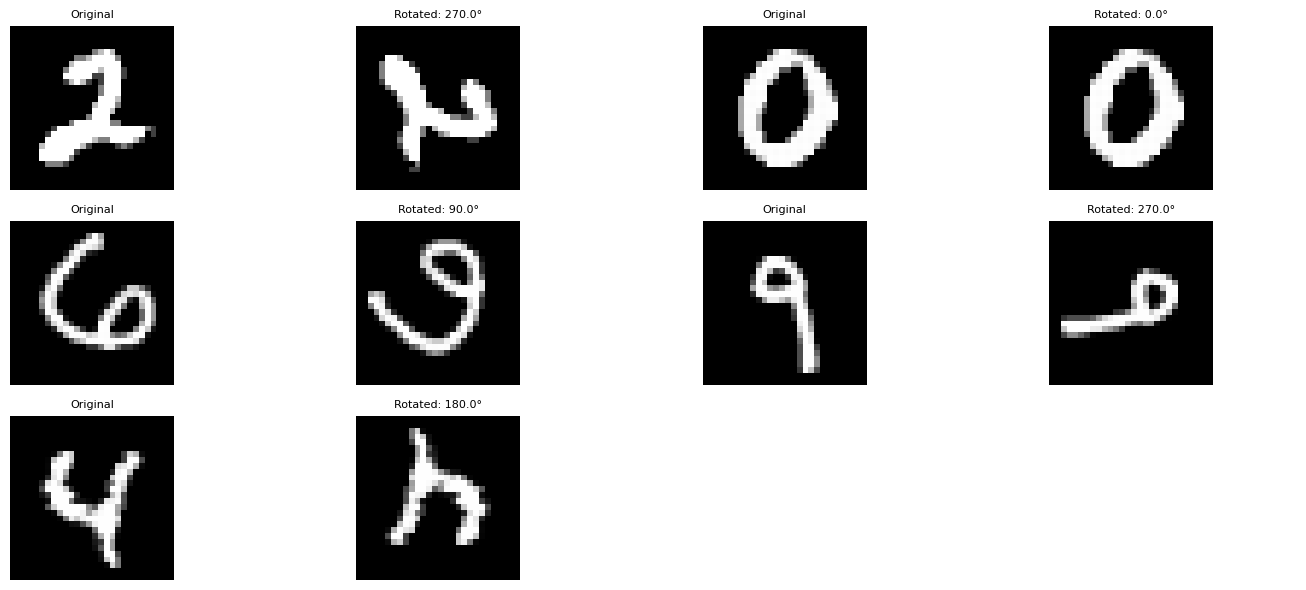

In [138]:
num_images = 5
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(14, num_rows * 2))

for i in range(num_images):
    idx = torch.randint(0, len(unsupervised_train_set), (1,)).item()
    original_image, _ =unsupervised_train_set[idx]

    rotation_angle = random.choice(rotations)
    rotated_image = transforms.functional.rotate(original_image, rotation_angle)

    original_image = original_image.squeeze(0).numpy()
    rotated_image = rotated_image.squeeze(0).numpy()

    row, col = divmod(i, num_cols)
    original_col = col * 2
    rotated_col = col * 2 + 1

    axes[row, original_col].imshow(original_image, cmap='gray')
    axes[row, original_col].set_title("Original", fontsize=8)
    axes[row, original_col].axis('off')

    axes[row, rotated_col].imshow(rotated_image, cmap='gray')
    axes[row, rotated_col].set_title(f"Rotated: {rotation_angle}°", fontsize=8)
    axes[row, rotated_col].axis('off')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()



# Train rotnet

In [139]:
unsupervised_train_loader = DataLoader(RotationDataset(unsupervised_train_set,
                                                       rotations=rotations), 
                                       batch_size=256,
                                       shuffle=True,
                                       num_workers=8,
                                       persistent_workers=True,
                                       collate_fn=rotation_collate)

unsupervised_val_loader = DataLoader(RotationDataset(unsupervised_val_set,
                                                     rotations=rotations), 
                                     batch_size=256, 
                                     shuffle=False,
                                     num_workers=8,
                                     persistent_workers=True,
                                     collate_fn=rotation_collate)



In [140]:
rotnet = ConvNet(num_classes=len(rotations),num_blocks=CONV_BLOCKS).cuda()
optimizer = torch.optim.Adam(rotnet.parameters(), lr=0.001,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

train_convnet(rotnet, 
                 unsupervised_train_loader, 
                 unsupervised_val_loader,
                 nn.CrossEntropyLoss(),
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=15,
                 filename=f'rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth')

    

0


Epoch 1/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 27.60it/s]


Epoch [1/15] - 
Train Loss: 0.1161, Train Accuracy: 96.28%, 
Validation Loss: 0.0353, Validation Accuracy: 98.89%



Epoch 2/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 40.17it/s]


Epoch [2/15] - 
Train Loss: 0.0236, Train Accuracy: 99.31%, 
Validation Loss: 0.0277, Validation Accuracy: 99.11%



Epoch 3/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 40.35it/s]


Epoch [3/15] - 
Train Loss: 0.0196, Train Accuracy: 99.41%, 
Validation Loss: 0.0280, Validation Accuracy: 99.10%



Epoch 4/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 39.88it/s]


Epoch [4/15] - 
Train Loss: 0.0179, Train Accuracy: 99.47%, 
Validation Loss: 0.0299, Validation Accuracy: 98.96%



Epoch 5/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 39.28it/s]


Epoch [5/15] - 
Train Loss: 0.0177, Train Accuracy: 99.46%, 
Validation Loss: 0.0272, Validation Accuracy: 99.04%



Epoch 6/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 39.51it/s]


Epoch [6/15] - 
Train Loss: 0.0169, Train Accuracy: 99.50%, 
Validation Loss: 0.0284, Validation Accuracy: 99.05%



Epoch 7/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 41.12it/s]


Epoch [7/15] - 
Train Loss: 0.0159, Train Accuracy: 99.53%, 
Validation Loss: 0.0243, Validation Accuracy: 99.23%



Epoch 8/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.06it/s]


Epoch [8/15] - 
Train Loss: 0.0167, Train Accuracy: 99.53%, 
Validation Loss: 0.0254, Validation Accuracy: 99.17%



Epoch 9/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.31it/s]


Epoch [9/15] - 
Train Loss: 0.0159, Train Accuracy: 99.54%, 
Validation Loss: 0.0241, Validation Accuracy: 99.19%



Epoch 10/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.77it/s]


Epoch [10/15] - 
Train Loss: 0.0161, Train Accuracy: 99.55%, 
Validation Loss: 0.0229, Validation Accuracy: 99.27%



Epoch 11/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.88it/s]


Epoch [11/15] - 
Train Loss: 0.0160, Train Accuracy: 99.54%, 
Validation Loss: 0.0251, Validation Accuracy: 99.16%



Epoch 12/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.50it/s]


Epoch [12/15] - 
Train Loss: 0.0148, Train Accuracy: 99.58%, 
Validation Loss: 0.0293, Validation Accuracy: 98.96%



Epoch 13/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.34it/s]


Epoch [13/15] - 
Train Loss: 0.0144, Train Accuracy: 99.59%, 
Validation Loss: 0.0257, Validation Accuracy: 99.13%



Epoch 14/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 37.66it/s]


Epoch [14/15] - 
Train Loss: 0.0147, Train Accuracy: 99.57%, 
Validation Loss: 0.0227, Validation Accuracy: 99.27%



Epoch 15/15 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.31it/s]

Epoch [15/15] - 
Train Loss: 0.0141, Train Accuracy: 99.59%, 
Validation Loss: 0.0303, Validation Accuracy: 98.96%



In [141]:
best_model=ConvNet(num_classes=len(rotations),num_blocks=CONV_BLOCKS).cuda()
best_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth'))    

/tmp/ipykernel_20047/3641225631.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth

<All keys matched successfully>

In [142]:
evaluate_classifier(best_model, unsupervised_val_loader)

Test Accuracy: 99.27%


## Transfer Encoder

#### Load RotNet model

In [149]:
rotnet_model=ConvNet(num_classes=len(rotations),num_blocks=CONV_BLOCKS).cuda()
rotnet_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth'))
rotnet_model=rotnet_model.cuda()

/tmp/ipykernel_20047/4161198983.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotnet_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.p

#### Transfer Layers

In [150]:
MNIST_model = ConvNet(num_classes=10,num_blocks=TRANSFER_LAYERS+1).cuda()
MNIST_model.transfer_layers(rotnet_model, num_transfer_blocks=TRANSFER_LAYERS)

Transferred 2 blocks from source model to target model.


In [151]:
MNIST_model

ConvNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=1)
  (classifica

In [152]:
supervised_train_loader = DataLoader(supervised_dataset, 
                                     batch_size=8, 
                                     shuffle=True,
                                     num_workers=4,
                                     persistent_workers=True)
supervised_val_loader = DataLoader(test_dataset, 
                                   batch_size=256, 
                                   shuffle=False,
                                   num_workers=4,
                                   persistent_workers=True)

optimizer=torch.optim.Adam(MNIST_model.parameters(),lr=0.01,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                          step_size=50, 
                                                          gamma=0.5)

train_convnet(MNIST_model, 
                 supervised_train_loader, 
                 supervised_val_loader,
                 nn.CrossEntropyLoss(),
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=40,
                 #num_frozen_blocks=TRANSFER_LAYERS,
                 #freezed_epochs=50,
                 filename=f'rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TRANSFER_LAYERS}.pth')

0


Epoch 1/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch [1/40] - 
Train Loss: 2.5430, Train Accuracy: 15.00%, 
Validation Loss: 2.3866, Validation Accuracy: 18.74%



Epoch 2/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 177.78it/s]


Epoch [2/40] - 
Train Loss: 1.9957, Train Accuracy: 33.00%, 
Validation Loss: 2.7594, Validation Accuracy: 11.50%



Epoch 3/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 202.36it/s]


Epoch [3/40] - 
Train Loss: 1.5519, Train Accuracy: 50.00%, 
Validation Loss: 3.0672, Validation Accuracy: 12.66%



Epoch 4/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 178.55it/s]


Epoch [4/40] - 
Train Loss: 1.1762, Train Accuracy: 67.00%, 
Validation Loss: 1.5644, Validation Accuracy: 44.43%



Epoch 5/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 206.73it/s]


Epoch [5/40] - 
Train Loss: 0.8290, Train Accuracy: 84.00%, 
Validation Loss: 1.9398, Validation Accuracy: 33.89%



Epoch 6/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 201.76it/s]


Epoch [6/40] - 
Train Loss: 0.5596, Train Accuracy: 93.00%, 
Validation Loss: 1.2196, Validation Accuracy: 57.81%



Epoch 7/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 216.22it/s]


Epoch [7/40] - 
Train Loss: 0.3600, Train Accuracy: 93.00%, 
Validation Loss: 1.6221, Validation Accuracy: 44.33%



Epoch 8/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 190.04it/s]


Epoch [8/40] - 
Train Loss: 0.2634, Train Accuracy: 94.00%, 
Validation Loss: 2.1697, Validation Accuracy: 50.81%



Epoch 9/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 196.82it/s]


Epoch [9/40] - 
Train Loss: 0.3753, Train Accuracy: 91.00%, 
Validation Loss: 2.0554, Validation Accuracy: 45.63%



Epoch 10/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 203.62it/s]


Epoch [10/40] - 
Train Loss: 0.2968, Train Accuracy: 95.00%, 
Validation Loss: 1.2887, Validation Accuracy: 61.78%



Epoch 11/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 217.95it/s]


Epoch [11/40] - 
Train Loss: 0.1843, Train Accuracy: 100.00%, 
Validation Loss: 1.0251, Validation Accuracy: 64.55%



Epoch 12/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 217.48it/s]


Epoch [12/40] - 
Train Loss: 0.1482, Train Accuracy: 95.00%, 
Validation Loss: 4.2761, Validation Accuracy: 23.64%



Epoch 13/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 227.04it/s]


Epoch [13/40] - 
Train Loss: 0.1007, Train Accuracy: 97.00%, 
Validation Loss: 1.1800, Validation Accuracy: 63.82%



Epoch 14/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 213.19it/s]


Epoch [14/40] - 
Train Loss: 0.0688, Train Accuracy: 100.00%, 
Validation Loss: 0.7306, Validation Accuracy: 76.02%



Epoch 15/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 194.27it/s]


Epoch [15/40] - 
Train Loss: 0.0493, Train Accuracy: 100.00%, 
Validation Loss: 0.5937, Validation Accuracy: 81.11%



Epoch 16/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 195.14it/s]


Epoch [16/40] - 
Train Loss: 0.0519, Train Accuracy: 99.00%, 
Validation Loss: 1.4322, Validation Accuracy: 61.03%



Epoch 17/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 219.47it/s]


Epoch [17/40] - 
Train Loss: 0.0399, Train Accuracy: 100.00%, 
Validation Loss: 0.7555, Validation Accuracy: 76.50%



Epoch 18/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 207.18it/s]


Epoch [18/40] - 
Train Loss: 0.0740, Train Accuracy: 99.00%, 
Validation Loss: 1.3455, Validation Accuracy: 55.75%



Epoch 19/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 202.04it/s]


Epoch [19/40] - 
Train Loss: 0.1631, Train Accuracy: 99.00%, 
Validation Loss: 1.7908, Validation Accuracy: 55.91%



Epoch 20/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 212.87it/s]


Epoch [20/40] - 
Train Loss: 0.2691, Train Accuracy: 92.00%, 
Validation Loss: 1.6265, Validation Accuracy: 54.47%



Epoch 21/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 207.21it/s]


Epoch [21/40] - 
Train Loss: 0.1943, Train Accuracy: 96.00%, 
Validation Loss: 2.0586, Validation Accuracy: 60.87%



Epoch 22/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 186.94it/s]


Epoch [22/40] - 
Train Loss: 0.1980, Train Accuracy: 93.00%, 
Validation Loss: 1.1621, Validation Accuracy: 68.28%



Epoch 23/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 192.53it/s]


Epoch [23/40] - 
Train Loss: 0.1298, Train Accuracy: 97.00%, 
Validation Loss: 1.3592, Validation Accuracy: 63.73%



Epoch 24/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 222.36it/s]


Epoch [24/40] - 
Train Loss: 0.1670, Train Accuracy: 96.00%, 
Validation Loss: 0.9354, Validation Accuracy: 73.90%



Epoch 25/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 225.11it/s]


Epoch [25/40] - 
Train Loss: 0.0638, Train Accuracy: 99.00%, 
Validation Loss: 1.2496, Validation Accuracy: 61.13%



Epoch 26/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 184.63it/s]


Epoch [26/40] - 
Train Loss: 0.0521, Train Accuracy: 99.00%, 
Validation Loss: 0.6262, Validation Accuracy: 79.93%



Epoch 27/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 200.28it/s]


Epoch [27/40] - 
Train Loss: 0.0121, Train Accuracy: 100.00%, 
Validation Loss: 0.5170, Validation Accuracy: 83.19%



Epoch 28/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 181.48it/s]


Epoch [28/40] - 
Train Loss: 0.0112, Train Accuracy: 100.00%, 
Validation Loss: 0.4455, Validation Accuracy: 85.81%



Epoch 29/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 201.64it/s]


Epoch [29/40] - 
Train Loss: 0.0120, Train Accuracy: 100.00%, 
Validation Loss: 0.6212, Validation Accuracy: 79.59%



Epoch 30/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 212.23it/s]


Epoch [30/40] - 
Train Loss: 0.0061, Train Accuracy: 100.00%, 
Validation Loss: 0.4637, Validation Accuracy: 84.93%



Epoch 31/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 197.78it/s]


Epoch [31/40] - 
Train Loss: 0.0075, Train Accuracy: 100.00%, 
Validation Loss: 0.4940, Validation Accuracy: 83.51%



Epoch 32/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 209.02it/s]


Epoch [32/40] - 
Train Loss: 0.0042, Train Accuracy: 100.00%, 
Validation Loss: 0.4631, Validation Accuracy: 84.73%



Epoch 33/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 202.10it/s]


Epoch [33/40] - 
Train Loss: 0.0038, Train Accuracy: 100.00%, 
Validation Loss: 0.4889, Validation Accuracy: 83.91%



Epoch 34/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 207.70it/s]


Epoch [34/40] - 
Train Loss: 0.0022, Train Accuracy: 100.00%, 
Validation Loss: 0.4713, Validation Accuracy: 84.53%



Epoch 35/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 223.59it/s]


Epoch [35/40] - 
Train Loss: 0.0021, Train Accuracy: 100.00%, 
Validation Loss: 0.4795, Validation Accuracy: 84.03%



Epoch 36/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 201.79it/s]


Epoch [36/40] - 
Train Loss: 0.0024, Train Accuracy: 100.00%, 
Validation Loss: 0.4950, Validation Accuracy: 83.69%



Epoch 37/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 209.64it/s]


Epoch [37/40] - 
Train Loss: 0.0017, Train Accuracy: 100.00%, 
Validation Loss: 0.4541, Validation Accuracy: 85.07%



Epoch 38/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 173.58it/s]


Epoch [38/40] - 
Train Loss: 0.0033, Train Accuracy: 100.00%, 
Validation Loss: 0.5093, Validation Accuracy: 83.00%



Epoch 39/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 211.65it/s]


Epoch [39/40] - 
Train Loss: 0.0021, Train Accuracy: 100.00%, 
Validation Loss: 0.4489, Validation Accuracy: 85.06%



Epoch 40/40 [Validation]: 100%|██████████| 40/40 [00:00<00:00, 182.08it/s]

Epoch [40/40] - 
Train Loss: 0.0019, Train Accuracy: 100.00%, 
Validation Loss: 0.4323, Validation Accuracy: 85.82%



In [153]:
best_mnist_model=ConvNet(num_classes=10,
                         num_blocks=TRANSFER_LAYERS+1,
                         checkpoint_path=f'models/rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TRANSFER_LAYERS}.pth').cuda()
evaluate_classifier(best_mnist_model, supervised_val_loader)

Test Accuracy: 85.82%
